In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm


In [8]:
# Target distribution $q_D$
N = 1000
Xs = np.random.randn(2 * N).reshape(N, 2)
Xs[:, 1] -= 2 * Xs[:, 0] ** 2
# Normalize data to zero mean, unit variance
Xs = (Xs - np.mean(Xs, axis=0).reshape(1, -1)) / np.std(Xs, axis=0).reshape(1, -1)

# Assert that the data is normalized
assert np.allclose(np.mean(Xs, axis=0), 0)
assert np.allclose(np.std(Xs, axis=0), 1)


In [9]:
T = 100
s = 0.008


def foo(t):
    return np.cos(np.pi / 2 * ((t / T + s) / (1 + s)))


def bar(t):
    return np.minimum(1.0 - foo(t) / foo(t - 1), 0.999)


def baz(T):
    tt = np.linspace(0, T, T)
    return np.array([bar(t) for t in tt])

In [10]:
qwerty = baz(T)

In [11]:
# neural network to learn epsilon(x_t,t)
class Net(nn.Module):
    def __init__(self, num_latent_features=32, num_embedding_features=16):
        super().__init__()
        self.num_embedding_features = num_embedding_features
        self.num_latent_features = num_latent_features
        self.fc_in = nn.Linear(2, num_latent_features)
        self.fc_emb = nn.Linear(num_embedding_features, num_latent_features)
        self.fc1 = nn.Linear(num_latent_features, num_latent_features)
        self.fc2 = nn.Linear(num_latent_features, num_latent_features)
        self.fc_out = nn.Linear(num_latent_features, 2)

    def embedding(self, t):
        num_frequencies = self.num_embedding_features // 2
        frequencies = torch.logspace(
            0, 3, num_frequencies, device=t.device, dtype=t.dtype
        )
        cos_feats = torch.cos(2 * np.pi * frequencies.unsqueeze(0) * t.unsqueeze(1))
        sin_feats = torch.sin(2 * np.pi * frequencies.unsqueeze(0) * t.unsqueeze(1))
        return torch.hstack([cos_feats, sin_feats])

    def forward(self, x, t):
        t_embedding = torch.nn.functional.silu(self.embedding(t))
        x = F.silu(self.fc_in(x) + self.fc_emb(t_embedding))
        x = F.silu(self.fc1(x))
        x = F.silu(self.fc2(x))
        x = self.fc_out(x)
        return x


In [12]:
def generate_betas(method, T=100):
    if method == "uniform":
        return 0.05 * torch.ones(T, dtype=torch.float32)
    elif method == "org_paper":
        beta_start = 1e-4
        beta_end = 0.02
        betas = np.linspace(beta_start, beta_end, T, dtype=np.float32)
        betas = torch.tensor(betas)
        return betas
    elif method == "complex":
        a = baz(T)
        return torch.tensor(a, dtype=torch.float32)


In [13]:
# Define betas
T = 100  # total diffusion steps

betas = generate_betas("complex", T=T)


In [14]:
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = torch.cat(
    (torch.tensor([1.0], dtype=torch.float32), alphas_cumprod), dim=0
)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)


In [15]:
baz = alphas_cumprod[:-1]

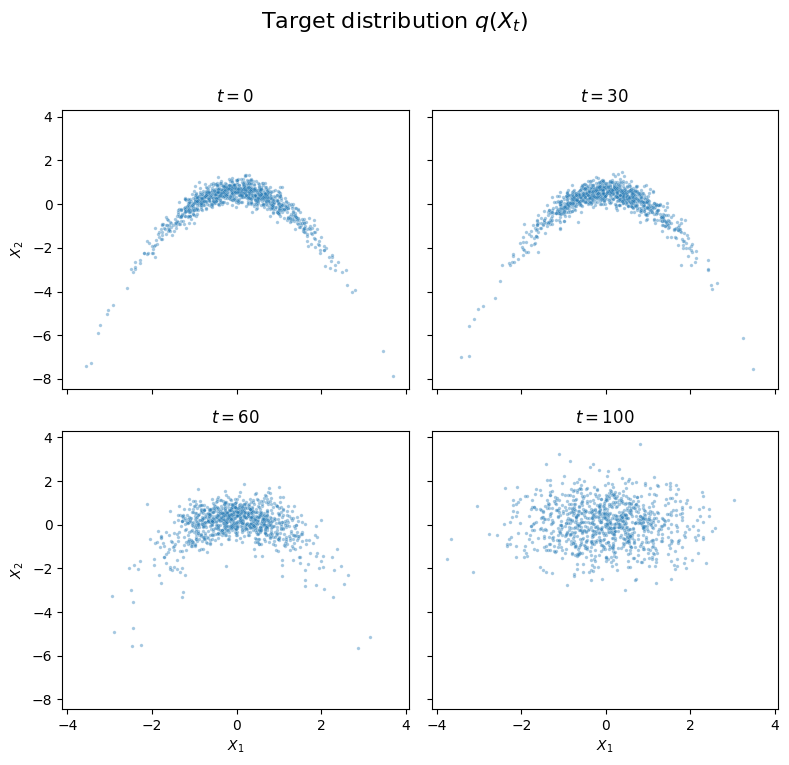

In [16]:
X_0 = Xs
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
axes = axes.flatten()
ts = [0, 30, 60, 100]

for idx, t in enumerate(ts):
    X_t = np.random.normal(
        loc=np.sqrt(alphas_cumprod_prev[t]) * X_0,
        scale=1.0 - alphas_cumprod_prev[t],
        size=(N, 2),
    )
    ax = axes[idx]
    sns.scatterplot(x=X_t[:, 0], y=X_t[:, 1], ax=ax, alpha=0.4, s=6)
    ax.set_title(f"$t={t}$")
    ax.set_xlabel("$X_1$")
    ax.set_ylabel("$X_2$")

fig.suptitle(r"Target distribution $q(X_t)$", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("./figures/target_distribution.png", dpi=600)
plt.show()


In [17]:
# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Net().to(device)

betas = betas.to(device)
alphas = alphas.to(device)
alphas_cumprod = alphas_cumprod.to(device)
alphas_cumprod_prev = alphas_cumprod_prev.to(device)
sqrt_alphas_cumprod = sqrt_alphas_cumprod.to(device)
sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.to(device)
sqrt_recip_alphas = sqrt_recip_alphas.to(device)

x_start = torch.tensor(Xs, dtype=torch.float32).to(device)

batch_size = 10
num_epochs = 500

dataset = torch.utils.data.TensorDataset(x_start)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [18]:
def loss_fn(Xs, model):
    batch_size_curr = Xs.size(0)
    t = torch.randint(0, T, (batch_size_curr,), device=device).long()
    epsilon = torch.randn_like(Xs).to(device)

    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t].reshape(-1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1)

    x_t = sqrt_alphas_cumprod_t * Xs + sqrt_one_minus_alphas_cumprod_t * epsilon

    t_normalized = t.float() / T

    epsilon_theta = model(x_t, t_normalized)

    loss = F.mse_loss(epsilon_theta, epsilon)
    return loss

In [19]:
for epoch in tqdm.trange(num_epochs):
    for batch in dataloader:
        x0 = batch[0].to(device)
        loss = loss_fn(x0, model)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 500/500 [00:17<00:00, 27.80it/s]


In [20]:
# Sampling
def p_sample(model, x, t):
    t_tensor = torch.full((x.size(0),), t, device=device, dtype=torch.long)
    t_normalized = t_tensor.float() / T
    epsilon_theta = model(x, t_normalized)
    beta_t = betas[t]
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t]
    sqrt_recip_alphas_t = sqrt_recip_alphas[t]
    x_prev = sqrt_recip_alphas_t * (
        x - (beta_t / sqrt_one_minus_alphas_cumprod_t) * epsilon_theta
    )
    if t > 0:
        noise = torch.randn_like(x)
        sigma_t = torch.sqrt(beta_t)
        x_prev = x_prev + sigma_t * noise
    return x_prev


In [29]:
def sample(model, num_samples):
    model.eval()
    with torch.no_grad():
        x = torch.randn(num_samples, 2).to(device)
        for t in reversed(range(T - 1)):
            x = p_sample(model, x, t)
    return x.cpu().numpy()


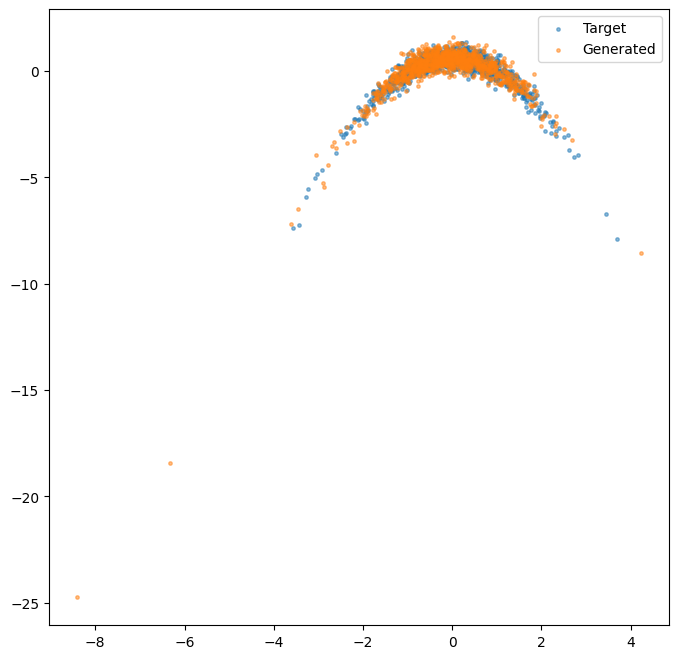

In [30]:
samples = sample(model, N)

plt.figure(figsize=(8, 8))
plt.scatter(Xs[:, 0], Xs[:, 1], alpha=0.5, s=6, label="Target")
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=6, label="Generated")
plt.legend()
plt.show()
